# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

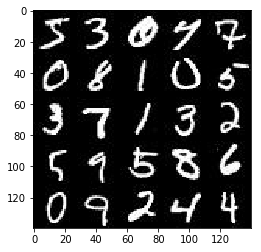

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

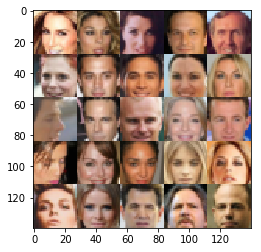

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    
    return  tf.placeholder(tf.float32,[None,image_width,image_height,image_channels]),\
            tf.placeholder(tf.float32,[None,z_dim]),\
            tf.placeholder(tf.float32)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse=not(is_train)):
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xdepth now

        #we divide by two to scale it to -0.5,0.5 like images
        out = tf.tanh(logits)/2
        
        #tf.summary.scalar('min_out_generator',tf.reduce_min(out))
        #tf.summary.scalar('max_out_generator',tf.reduce_max(out))
        #tf.summary.histogram('out_hist_generator',out)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    


    

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    #with tf.name_scope("model_loss"):
    #    tf.summary.histogram('histogram_d_logits_fake',d_logits_fake)
    #    tf.summary.scalar('g_loss',g_loss)
    #    tf.summary.scalar('d_loss',d_loss)
                
        
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("discriminator_1/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learning_rate_ph = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z,data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    
    samples, losses = [], []
    
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                rescaled_images = batch_images               
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                
 
                steps += 1       
                #tb_summary = tf.summary.merge_all()    
                _ = sess.run(d_opt, feed_dict={input_real: rescaled_images, input_z: batch_z, learning_rate_ph:learning_rate})
                #we run twice the generator learning to help it. without that discriminator is too good and generator get lost.
                _ = sess.run(g_opt, feed_dict={input_real: rescaled_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: rescaled_images, input_z: batch_z, learning_rate_ph:learning_rate})

                if steps % 10 == 0:
                        # At the end of each epoch, get the losses and print them out
                        train_loss_d = d_loss.eval({input_z: batch_z, input_real: rescaled_images})
                        train_loss_g = g_loss.eval({input_z: batch_z})

                        print("Epoch {}/{}...".format(epoch_i+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                        # Save losses to view after training
                        losses.append((train_loss_d, train_loss_g))

                if steps % 20 == 0:
                    if data_shape[3]==1:
                        show_generator_output(sess, 10, input_z, 1, "L")
                    if data_shape[3]==3:
                        show_generator_output(sess, 10, input_z, 3, "RGB")
                    
            
    return losses, samples      


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Tensor("discriminator_1/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Epoch 1/2... Discriminator Loss: 2.7798... Generator Loss: 0.2025
Epoch 1/2... Discriminator Loss: 2.8735... Generator Loss: 0.1301


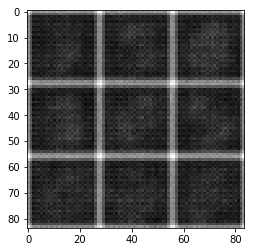

Epoch 1/2... Discriminator Loss: 3.1352... Generator Loss: 0.0892
Epoch 1/2... Discriminator Loss: 2.3918... Generator Loss: 0.2206


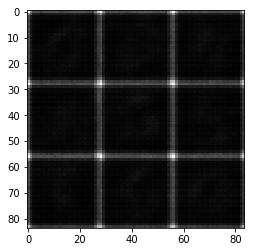

Epoch 1/2... Discriminator Loss: 2.1349... Generator Loss: 0.3471
Epoch 1/2... Discriminator Loss: 2.1618... Generator Loss: 0.2422


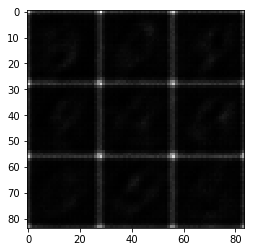

Epoch 1/2... Discriminator Loss: 2.0989... Generator Loss: 0.2779
Epoch 1/2... Discriminator Loss: 2.0418... Generator Loss: 0.2614


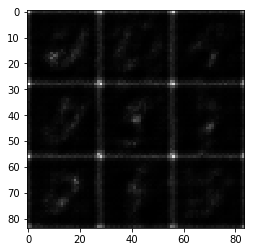

Epoch 1/2... Discriminator Loss: 2.3109... Generator Loss: 0.2680
Epoch 1/2... Discriminator Loss: 2.0787... Generator Loss: 0.2721


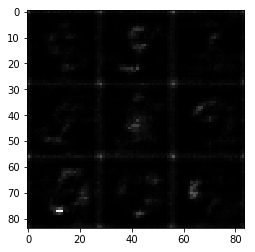

Epoch 1/2... Discriminator Loss: 2.1225... Generator Loss: 0.4348
Epoch 1/2... Discriminator Loss: 1.8938... Generator Loss: 0.2962


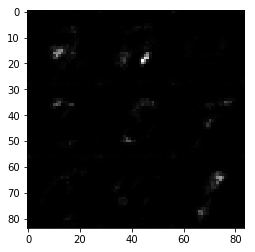

Epoch 1/2... Discriminator Loss: 1.9951... Generator Loss: 0.2783
Epoch 1/2... Discriminator Loss: 2.0168... Generator Loss: 0.2412


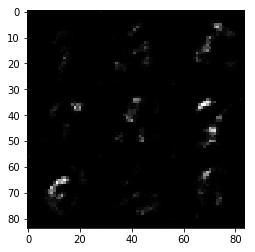

Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 0.4940
Epoch 1/2... Discriminator Loss: 1.8170... Generator Loss: 0.3041


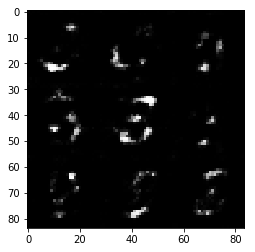

Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.5237
Epoch 1/2... Discriminator Loss: 1.6302... Generator Loss: 0.3809


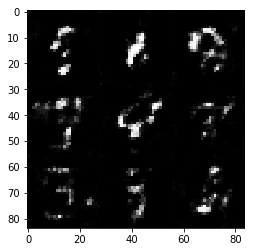

Epoch 1/2... Discriminator Loss: 1.5947... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 1.7555... Generator Loss: 0.2751


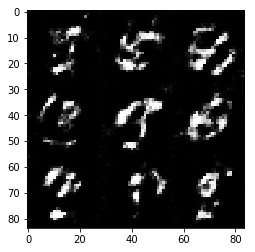

Epoch 1/2... Discriminator Loss: 1.6980... Generator Loss: 0.3148
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.5691


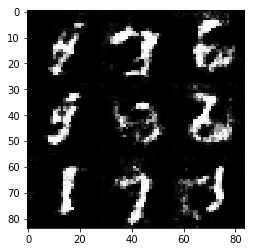

Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 1.7217... Generator Loss: 0.3795


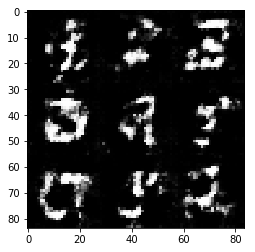

Epoch 1/2... Discriminator Loss: 1.8653... Generator Loss: 0.3099
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.6600


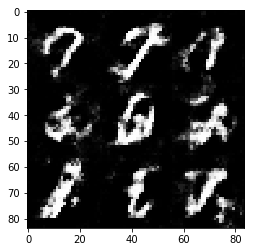

Epoch 1/2... Discriminator Loss: 1.9011... Generator Loss: 0.3547
Epoch 1/2... Discriminator Loss: 1.7734... Generator Loss: 0.3587


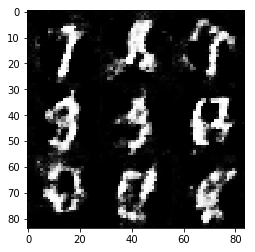

Epoch 1/2... Discriminator Loss: 2.0341... Generator Loss: 0.2125
Epoch 1/2... Discriminator Loss: 1.9252... Generator Loss: 0.4070


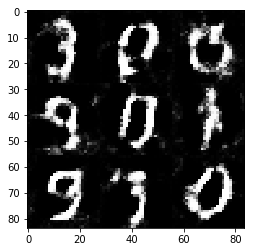

Epoch 1/2... Discriminator Loss: 1.7055... Generator Loss: 0.2990
Epoch 1/2... Discriminator Loss: 2.1911... Generator Loss: 0.1605


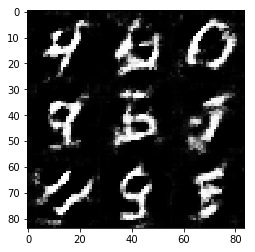

Epoch 1/2... Discriminator Loss: 1.9654... Generator Loss: 0.2988
Epoch 1/2... Discriminator Loss: 1.6925... Generator Loss: 0.3830


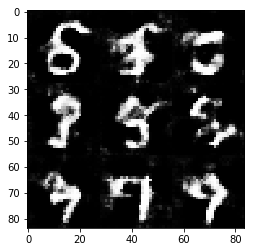

Epoch 1/2... Discriminator Loss: 1.8238... Generator Loss: 0.3920
Epoch 1/2... Discriminator Loss: 1.8106... Generator Loss: 0.3034


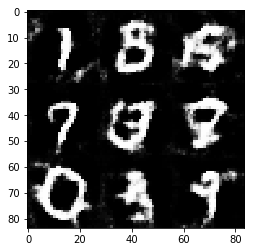

Epoch 1/2... Discriminator Loss: 1.7260... Generator Loss: 0.2683
Epoch 1/2... Discriminator Loss: 1.6130... Generator Loss: 0.4119


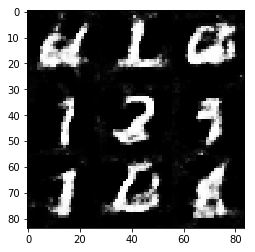

Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 0.4377
Epoch 1/2... Discriminator Loss: 1.8076... Generator Loss: 0.2604


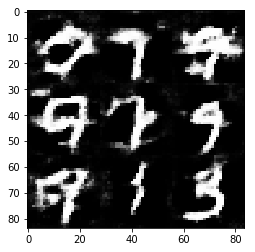

Epoch 1/2... Discriminator Loss: 1.9045... Generator Loss: 0.2625
Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 0.5981


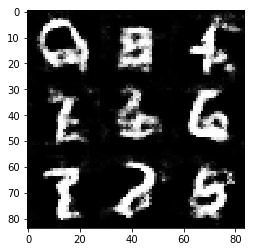

Epoch 1/2... Discriminator Loss: 1.5856... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 2.1543... Generator Loss: 0.2030


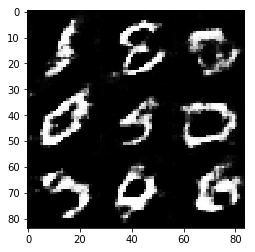

Epoch 1/2... Discriminator Loss: 1.6061... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 1.5416... Generator Loss: 0.4905


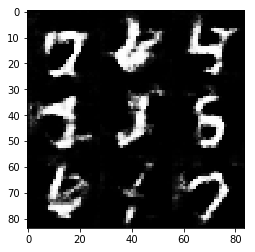

Epoch 1/2... Discriminator Loss: 1.5907... Generator Loss: 0.3607
Epoch 1/2... Discriminator Loss: 1.5580... Generator Loss: 0.4044


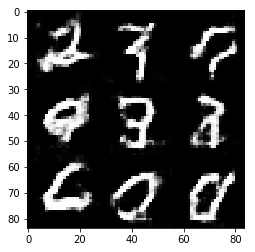

Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 0.3369


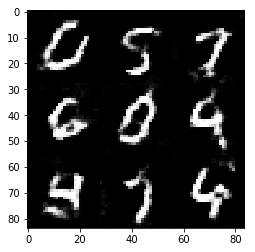

Epoch 1/2... Discriminator Loss: 1.6667... Generator Loss: 0.4439
Epoch 1/2... Discriminator Loss: 1.6141... Generator Loss: 0.3294


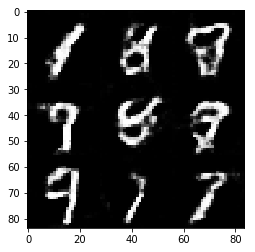

Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.3832
Epoch 1/2... Discriminator Loss: 1.6820... Generator Loss: 0.3097


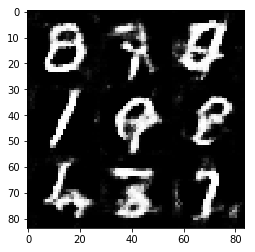

Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 0.4260
Epoch 1/2... Discriminator Loss: 1.6820... Generator Loss: 0.6840


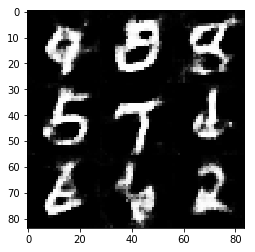

Epoch 1/2... Discriminator Loss: 1.7326... Generator Loss: 0.3020
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 0.4543


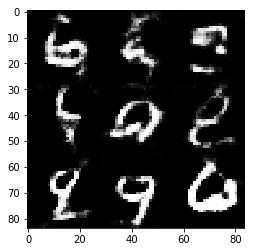

Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 1.7308... Generator Loss: 0.3597


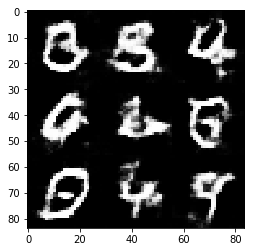

Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.4994


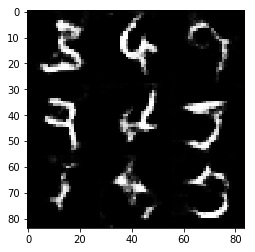

Epoch 1/2... Discriminator Loss: 1.6992... Generator Loss: 0.3427
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.7057


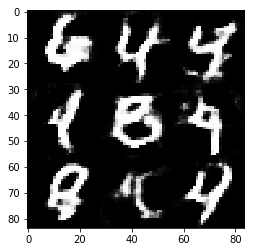

Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 1.6132... Generator Loss: 0.4021


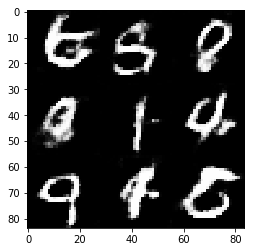

Epoch 1/2... Discriminator Loss: 1.6712... Generator Loss: 0.4680
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.5075


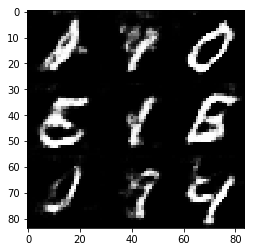

Epoch 1/2... Discriminator Loss: 1.6110... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 0.5196


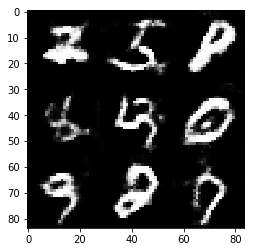

Epoch 1/2... Discriminator Loss: 2.0693... Generator Loss: 0.2008
Epoch 1/2... Discriminator Loss: 1.6256... Generator Loss: 0.3594


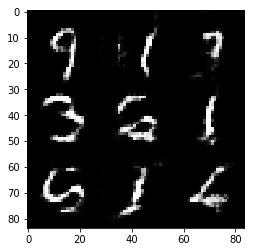

Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.3847
Epoch 1/2... Discriminator Loss: 1.6896... Generator Loss: 0.3671


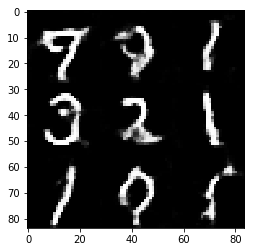

Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.7804


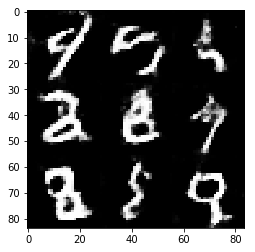

Epoch 1/2... Discriminator Loss: 1.5414... Generator Loss: 0.3933
Epoch 1/2... Discriminator Loss: 1.7150... Generator Loss: 0.3541


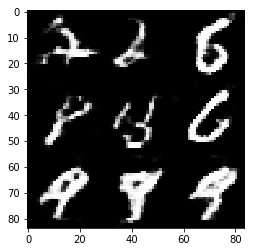

Epoch 1/2... Discriminator Loss: 1.7638... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 1.7965... Generator Loss: 0.2808


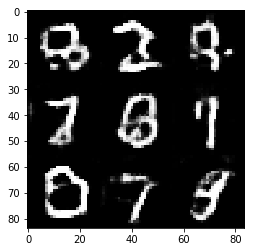

Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.5054


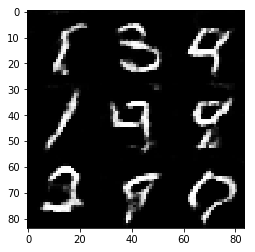

Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.3913
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.7155


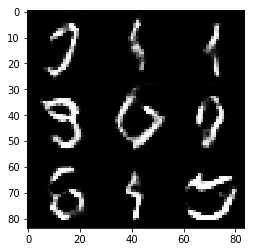

Epoch 1/2... Discriminator Loss: 1.8681... Generator Loss: 0.2280
Epoch 1/2... Discriminator Loss: 1.5680... Generator Loss: 0.4347


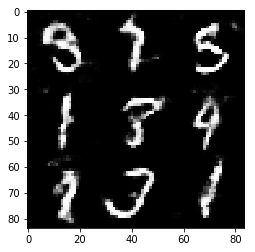

Epoch 1/2... Discriminator Loss: 1.6039... Generator Loss: 0.3927
Epoch 1/2... Discriminator Loss: 1.6237... Generator Loss: 0.3321


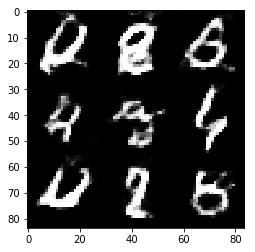

Epoch 1/2... Discriminator Loss: 1.5626... Generator Loss: 0.3989
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.4792


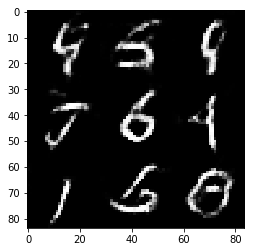

Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 1.5789... Generator Loss: 0.3468


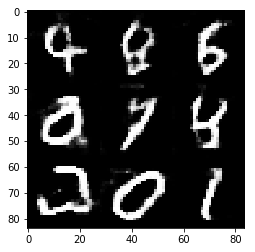

Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 1.6188... Generator Loss: 0.3280


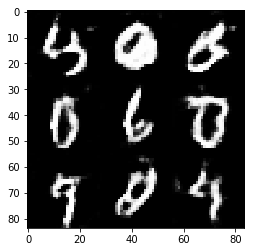

Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.8717
Epoch 1/2... Discriminator Loss: 1.0966... Generator Loss: 0.7042


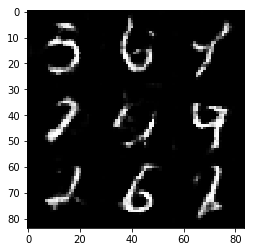

Epoch 1/2... Discriminator Loss: 1.5977... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.9155


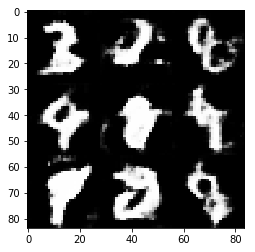

Epoch 1/2... Discriminator Loss: 1.6369... Generator Loss: 0.3188
Epoch 1/2... Discriminator Loss: 1.4133... Generator Loss: 0.4529


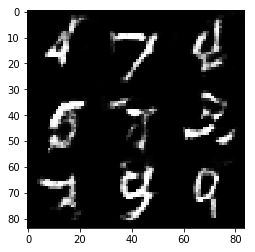

Epoch 1/2... Discriminator Loss: 1.7868... Generator Loss: 0.2429
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.5356


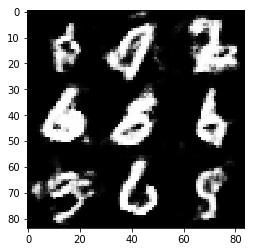

Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.3488
Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.5449


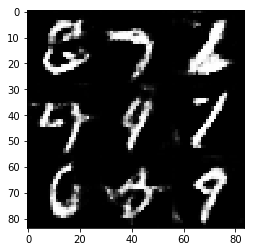

Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.4378
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 0.5205


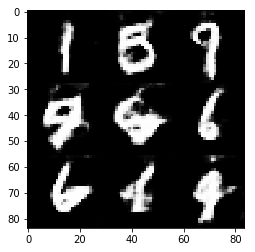

Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.3744


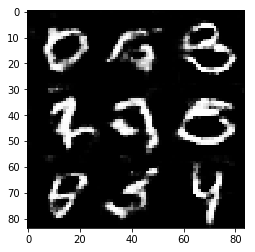

Epoch 1/2... Discriminator Loss: 1.8419... Generator Loss: 0.2466
Epoch 1/2... Discriminator Loss: 1.6344... Generator Loss: 0.3045


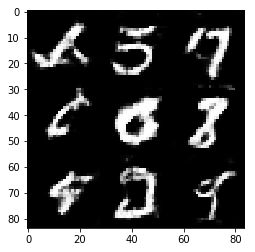

Epoch 1/2... Discriminator Loss: 1.6764... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.4939


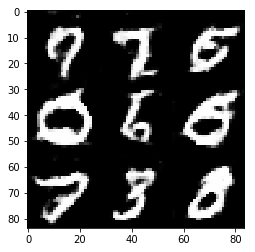

Epoch 1/2... Discriminator Loss: 1.6023... Generator Loss: 0.3052
Epoch 1/2... Discriminator Loss: 1.6273... Generator Loss: 0.3297


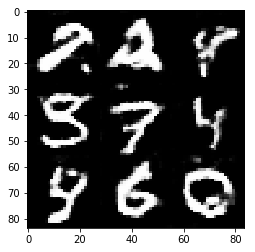

Epoch 1/2... Discriminator Loss: 1.5712... Generator Loss: 0.3834
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.3753


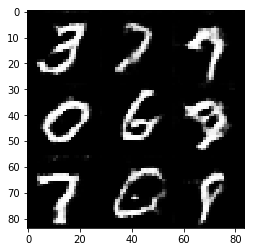

Epoch 1/2... Discriminator Loss: 1.7640... Generator Loss: 0.2536
Epoch 1/2... Discriminator Loss: 1.5145... Generator Loss: 0.3369


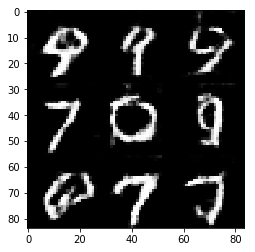

Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.6784


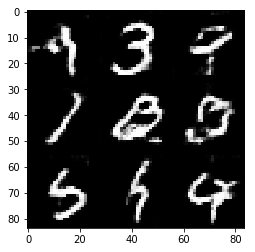

Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.6444
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.6931


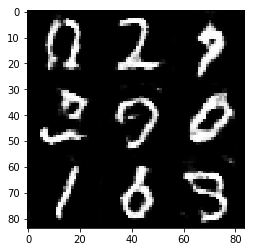

Epoch 1/2... Discriminator Loss: 1.6496... Generator Loss: 0.2819
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.5616


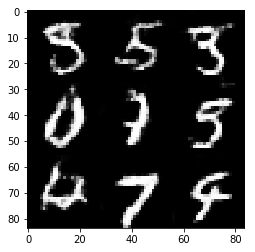

Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.3699
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.5811


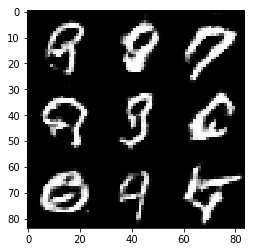

Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.4555


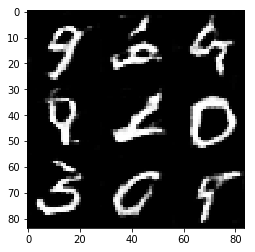

Epoch 1/2... Discriminator Loss: 1.7230... Generator Loss: 0.2510
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.5032


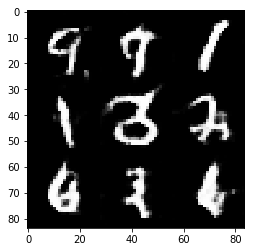

Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.9108... Generator Loss: 0.2538


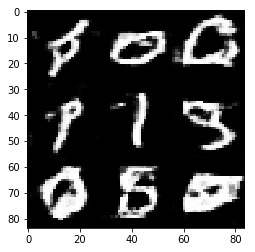

Epoch 1/2... Discriminator Loss: 1.6196... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.4179


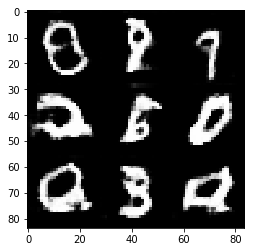

Epoch 1/2... Discriminator Loss: 1.2896... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 2.1073... Generator Loss: 0.1911


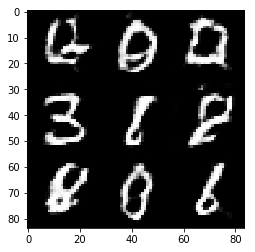

Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 0.3611


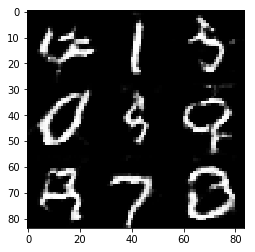

Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.6748... Generator Loss: 0.3167


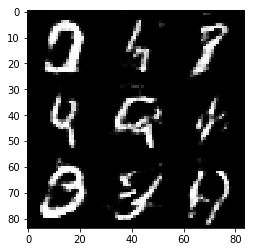

Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 0.3873


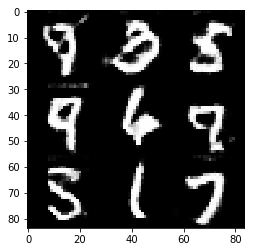

Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 2.3403... Generator Loss: 2.0347


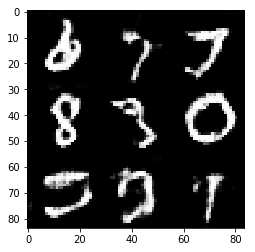

Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.3554
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.4295


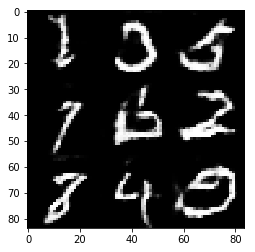

Epoch 1/2... Discriminator Loss: 2.1322... Generator Loss: 0.1578
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 0.6618


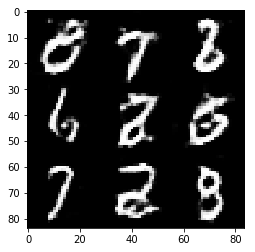

Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.3505
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 0.5506


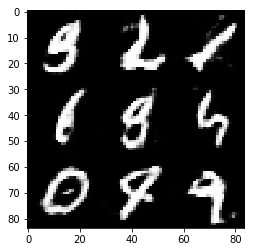

Epoch 1/2... Discriminator Loss: 1.8673... Generator Loss: 0.2280
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.5637


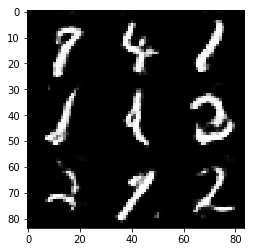

Epoch 1/2... Discriminator Loss: 1.8727... Generator Loss: 0.2095
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.3994


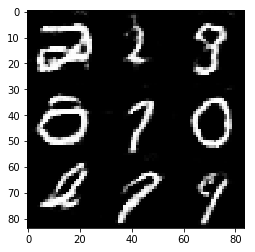

Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.5394
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 0.5854


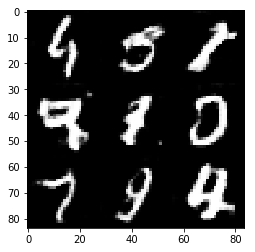

Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.3971


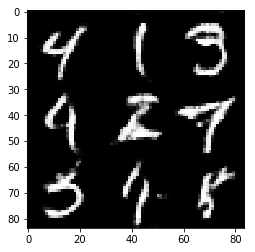

Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.6404... Generator Loss: 0.4364


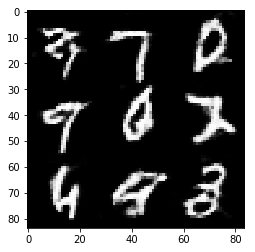

Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.6405
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.4089


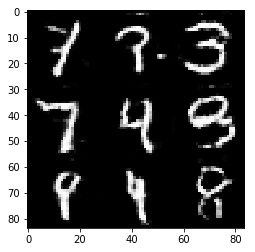

Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 0.4970
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.5833


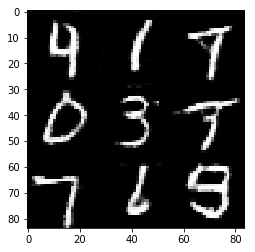

Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 1.0536
Epoch 1/2... Discriminator Loss: 1.6513... Generator Loss: 0.3529


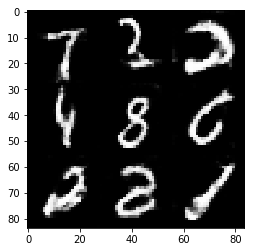

Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.4144
Epoch 1/2... Discriminator Loss: 0.6885... Generator Loss: 1.1763


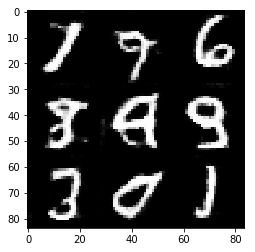

Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.4366
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.6274


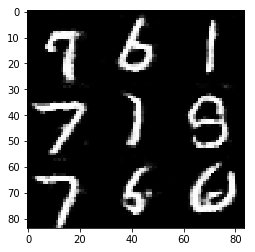

Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 0.6282... Generator Loss: 2.8068


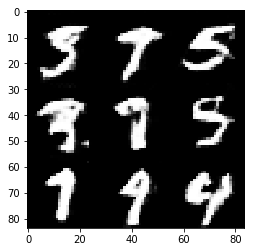

Epoch 1/2... Discriminator Loss: 1.4929... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 1.8119... Generator Loss: 0.6348


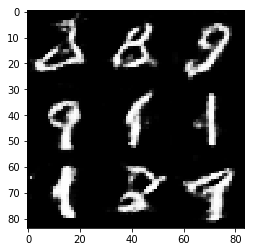

Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.4809... Generator Loss: 0.3447


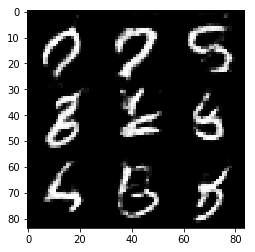

Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.6967


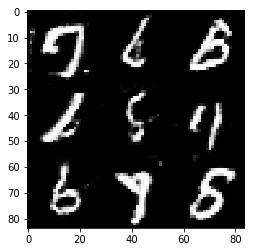

Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.6514


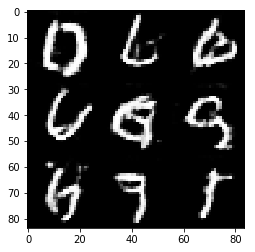

Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 0.3308


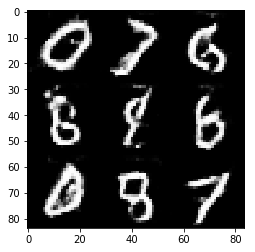

Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.4510
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.4292


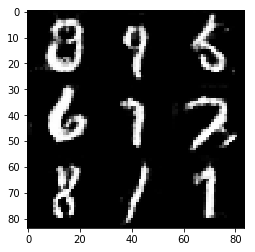

Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.8504
Epoch 1/2... Discriminator Loss: 1.6492... Generator Loss: 0.3183


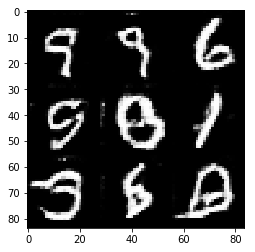

Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.5896
Epoch 2/2... Discriminator Loss: 1.5604... Generator Loss: 0.3015


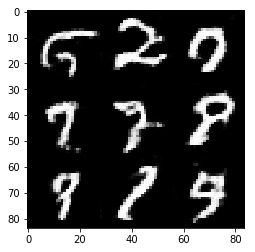

Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.4421
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.6859


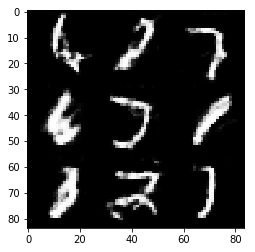

Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.6928... Generator Loss: 0.2825


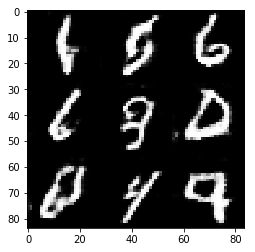

Epoch 2/2... Discriminator Loss: 1.5273... Generator Loss: 0.3628
Epoch 2/2... Discriminator Loss: 1.6848... Generator Loss: 0.2544


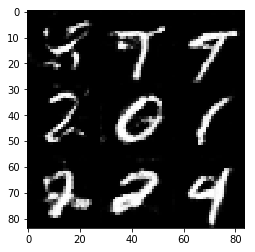

Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.6201
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.7141


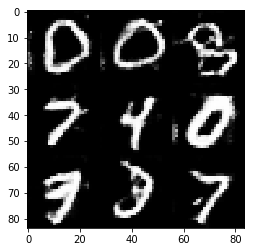

Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 1.8738... Generator Loss: 0.2424


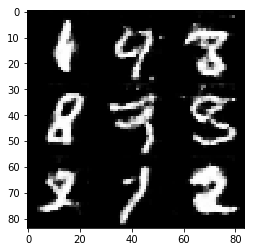

Epoch 2/2... Discriminator Loss: 1.5442... Generator Loss: 0.3300
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.4329


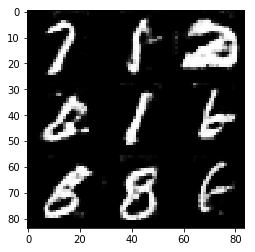

Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 0.7589
Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 0.5313


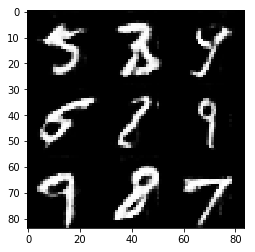

Epoch 2/2... Discriminator Loss: 1.6648... Generator Loss: 0.2810
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 0.6421


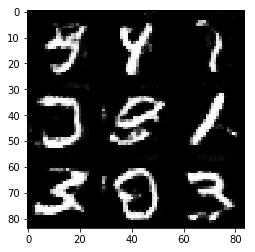

Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.5043
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.0539


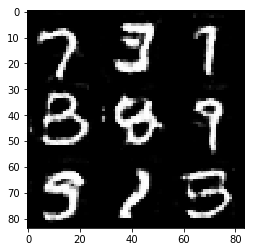

Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 1.5284... Generator Loss: 0.3922


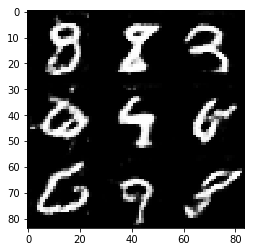

Epoch 2/2... Discriminator Loss: 2.1277... Generator Loss: 0.1634
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 0.5542


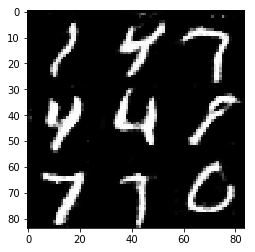

Epoch 2/2... Discriminator Loss: 1.7997... Generator Loss: 0.2491
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 0.5571


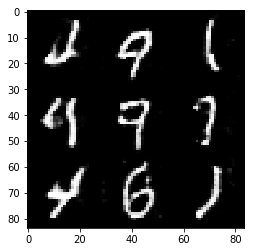

Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.3693
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 1.5569


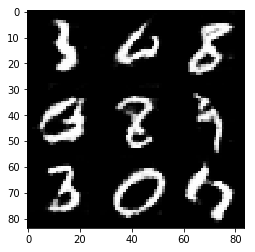

Epoch 2/2... Discriminator Loss: 1.7234... Generator Loss: 0.3093
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.4683


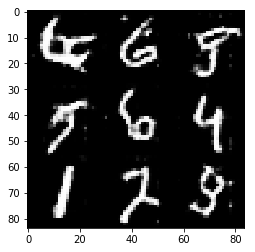

Epoch 2/2... Discriminator Loss: 1.7287... Generator Loss: 0.2890
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.7071


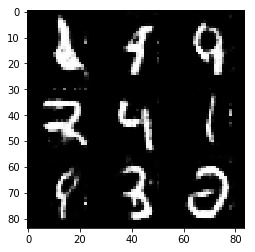

Epoch 2/2... Discriminator Loss: 1.2295... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.3912


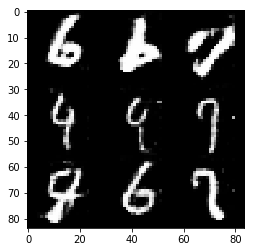

Epoch 2/2... Discriminator Loss: 1.5553... Generator Loss: 0.4985
Epoch 2/2... Discriminator Loss: 0.5728... Generator Loss: 1.4095


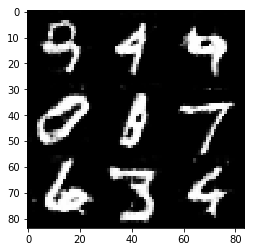

Epoch 2/2... Discriminator Loss: 1.6012... Generator Loss: 1.5675
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 0.8749


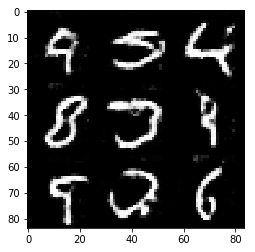

Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.5787


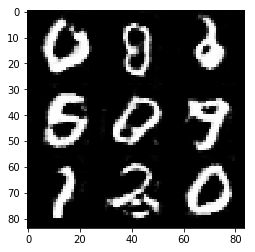

Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.5304
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.4782


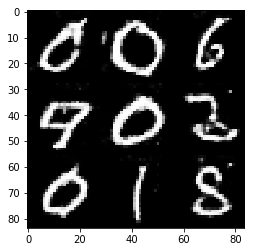

Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.6360


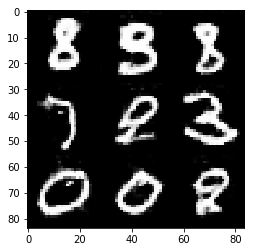

Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.5437
Epoch 2/2... Discriminator Loss: 1.6113... Generator Loss: 0.3518


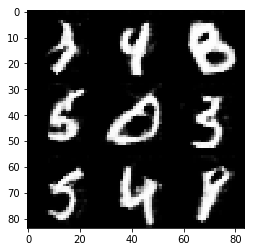

Epoch 2/2... Discriminator Loss: 1.1916... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.8017


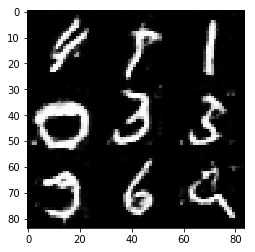

Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 0.3624


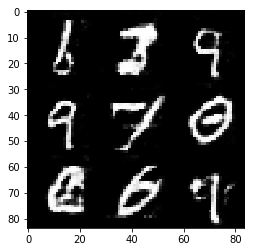

Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 0.5535
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.5506


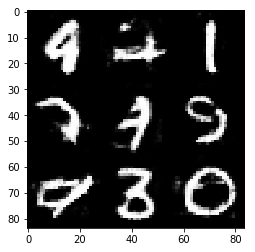

Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 0.6560
Epoch 2/2... Discriminator Loss: 1.5500... Generator Loss: 0.3616


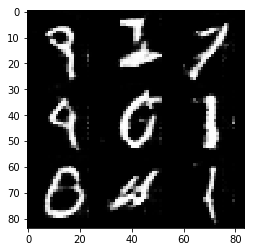

Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.5152


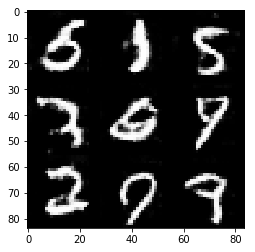

Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.6107
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.3846


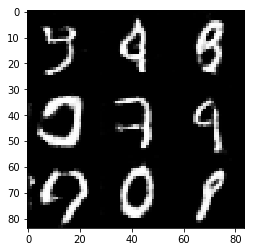

Epoch 2/2... Discriminator Loss: 1.5129... Generator Loss: 0.5223
Epoch 2/2... Discriminator Loss: 2.2058... Generator Loss: 0.1806


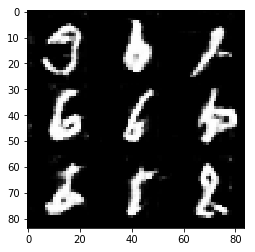

Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.4572
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.6786


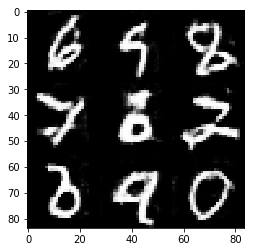

Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.5498
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.3526


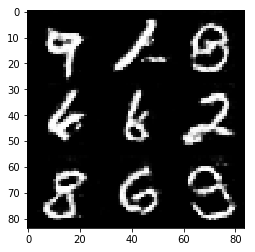

Epoch 2/2... Discriminator Loss: 1.5990... Generator Loss: 0.4694
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.8014


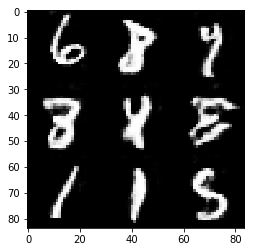

Epoch 2/2... Discriminator Loss: 1.6977... Generator Loss: 0.2819
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.4274


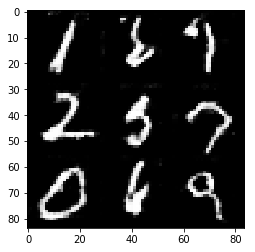

Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.4318
Epoch 2/2... Discriminator Loss: 1.5665... Generator Loss: 0.3839


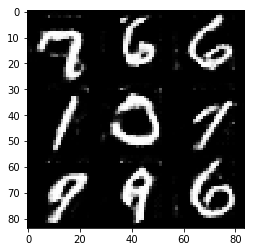

Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.6209


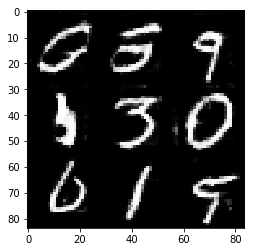

Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 0.5177
Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 0.5941


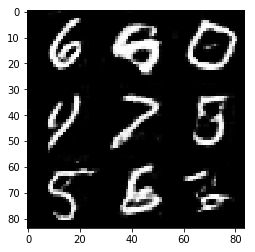

Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.3871
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 0.7982


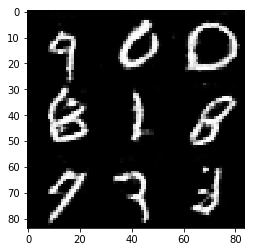

Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.4075
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.4602


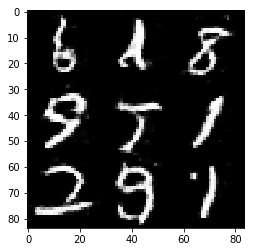

Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 0.7694


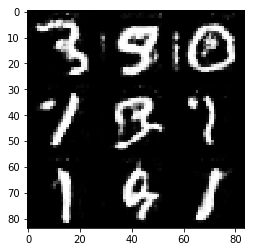

Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 1.6801


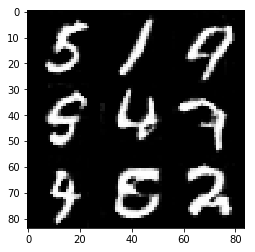

Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.5433


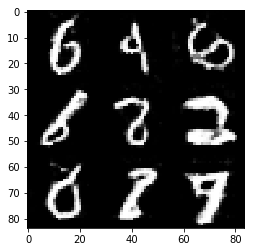

Epoch 2/2... Discriminator Loss: 0.9522... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 1.7291... Generator Loss: 0.2660


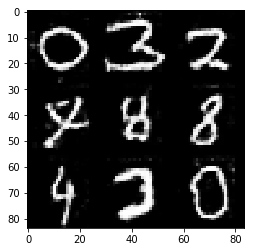

Epoch 2/2... Discriminator Loss: 1.6314... Generator Loss: 0.3716
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 0.8024


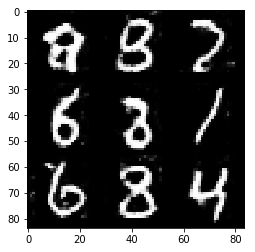

Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.5500
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.6199


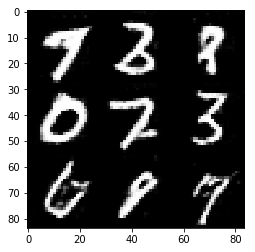

Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.4713
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 0.9837


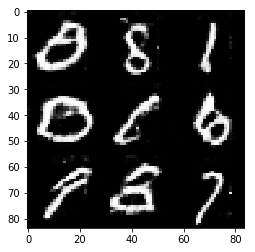

Epoch 2/2... Discriminator Loss: 1.8217... Generator Loss: 0.2353
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.4840


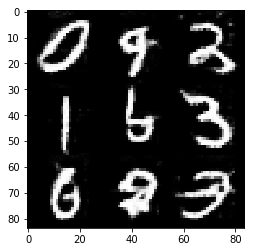

Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.4684
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.4581


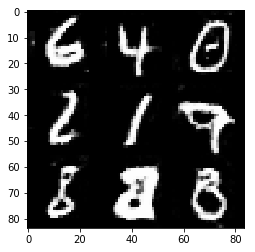

Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.0409
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.7138


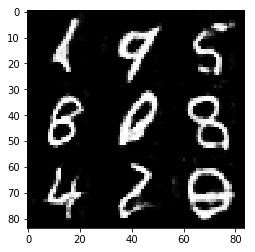

Epoch 2/2... Discriminator Loss: 1.8063... Generator Loss: 0.2634
Epoch 2/2... Discriminator Loss: 1.6562... Generator Loss: 0.3625


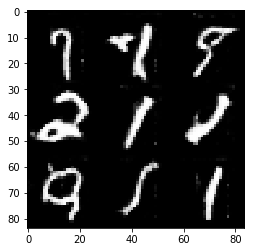

Epoch 2/2... Discriminator Loss: 1.6985... Generator Loss: 0.2904
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 0.8493


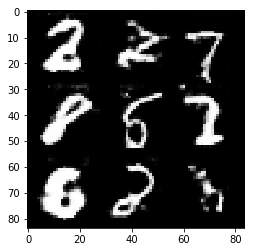

Epoch 2/2... Discriminator Loss: 1.4469... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.5541


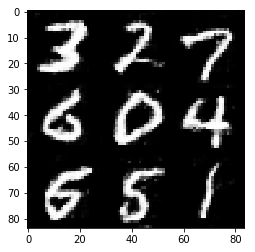

Epoch 2/2... Discriminator Loss: 2.2812... Generator Loss: 0.1612
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.4757


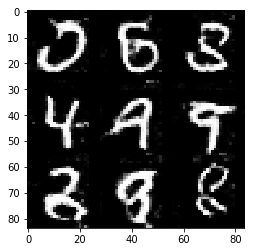

Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 1.4521... Generator Loss: 0.4033


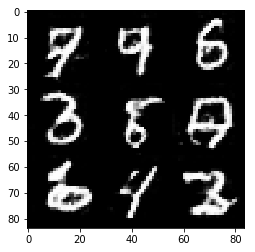

Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.4278


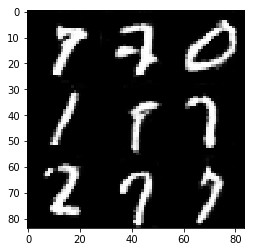

Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.5904


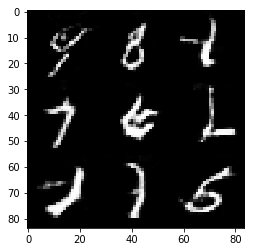

Epoch 2/2... Discriminator Loss: 1.6543... Generator Loss: 0.2942
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.4843


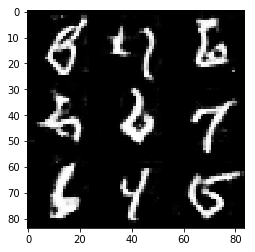

Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.4153


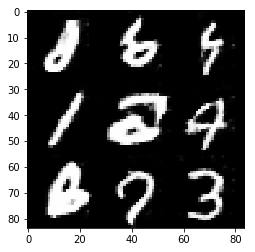

Epoch 2/2... Discriminator Loss: 1.1756... Generator Loss: 0.5206
Epoch 2/2... Discriminator Loss: 1.5309... Generator Loss: 0.4535


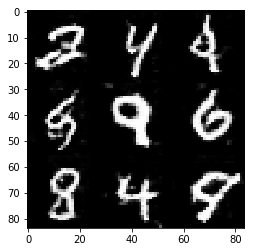

Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 0.8768


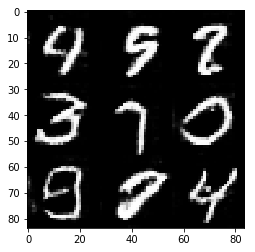

Epoch 2/2... Discriminator Loss: 1.1964... Generator Loss: 0.5776
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.4108


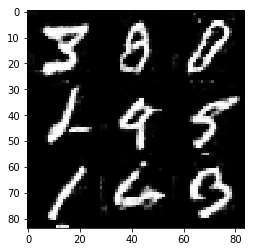

Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.4789


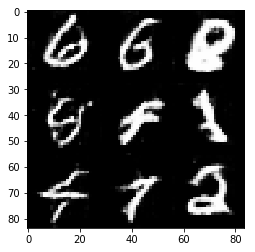

Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.3900
Epoch 2/2... Discriminator Loss: 1.5950... Generator Loss: 0.3058


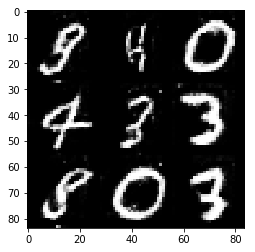

Epoch 2/2... Discriminator Loss: 1.9193... Generator Loss: 0.2515
Epoch 2/2... Discriminator Loss: 1.8539... Generator Loss: 0.2337


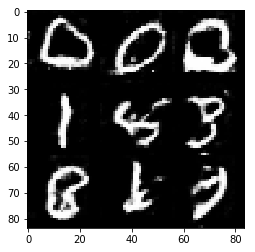

Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.3986
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.3867


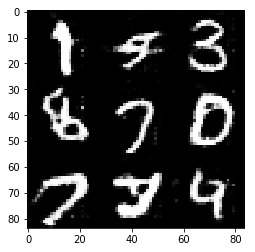

Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.4347


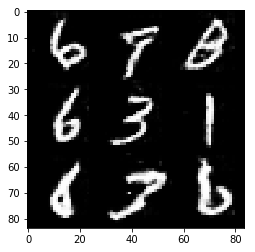

Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.6934


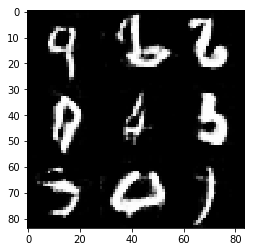

Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.4100... Generator Loss: 0.6463


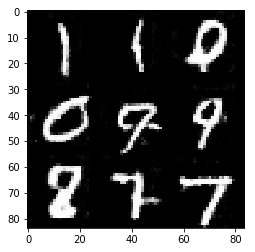

Epoch 2/2... Discriminator Loss: 1.5580... Generator Loss: 0.4195
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.5193


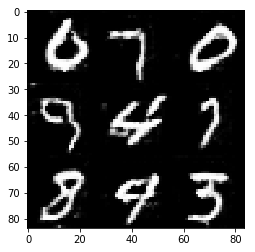

Epoch 2/2... Discriminator Loss: 1.8228... Generator Loss: 0.2900
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 0.7691


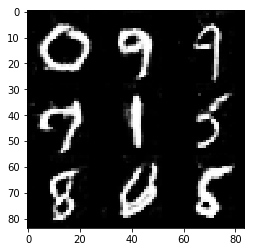

Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.5623... Generator Loss: 0.4346


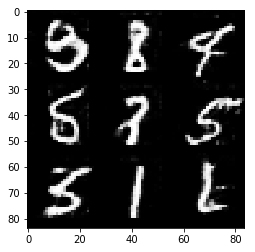

Epoch 2/2... Discriminator Loss: 1.6495... Generator Loss: 0.3516
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 1.0574


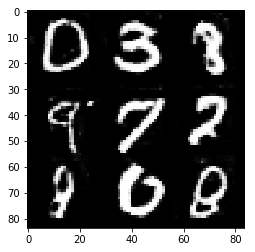

Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.2374... Generator Loss: 0.4633


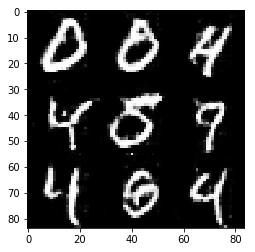

Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 0.6300


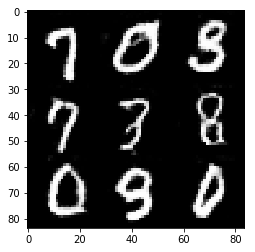

Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 0.5948


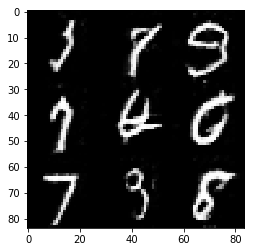

Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.3627
Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 0.4602


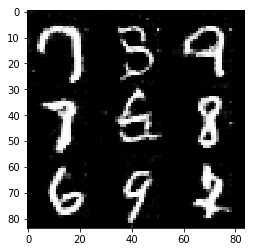

Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.5496
Epoch 2/2... Discriminator Loss: 1.5762... Generator Loss: 0.3378


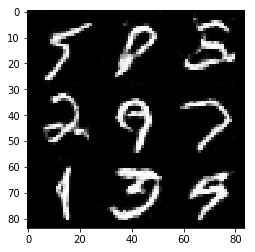

Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.4672


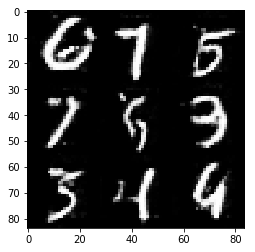

Epoch 2/2... Discriminator Loss: 1.8858... Generator Loss: 0.2816
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.4320


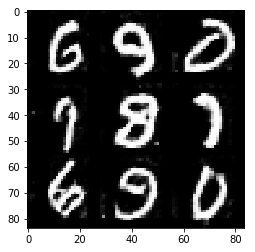

Epoch 2/2... Discriminator Loss: 1.5139... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.4719


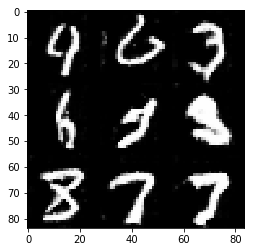

Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 0.6213
Epoch 2/2... Discriminator Loss: 0.4910... Generator Loss: 1.4916


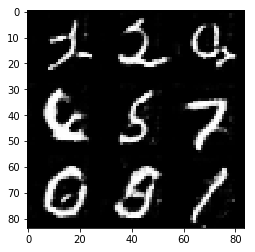

Epoch 2/2... Discriminator Loss: 1.6291... Generator Loss: 0.3352
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.2586


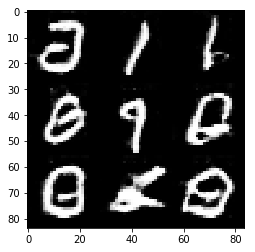

Epoch 2/2... Discriminator Loss: 0.9076... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 0.8306


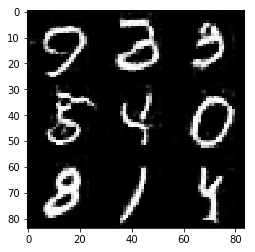

Epoch 2/2... Discriminator Loss: 1.8550... Generator Loss: 0.2438
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.5045


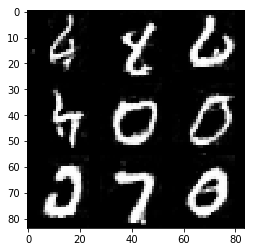

Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 0.5614


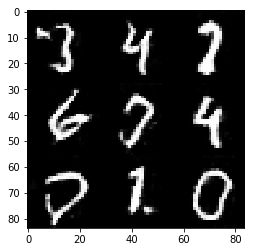

Epoch 2/2... Discriminator Loss: 2.1124... Generator Loss: 0.2261
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.4865


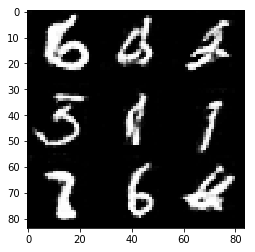

Epoch 2/2... Discriminator Loss: 2.4896... Generator Loss: 0.1434
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.8424


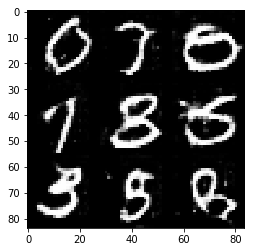

Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 1.2751


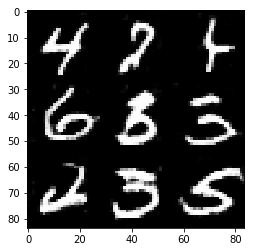

Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 0.6146
Epoch 2/2... Discriminator Loss: 1.6544... Generator Loss: 0.2949


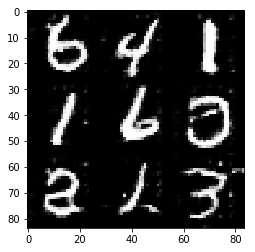

Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.5952
Epoch 2/2... Discriminator Loss: 1.5764... Generator Loss: 0.3948


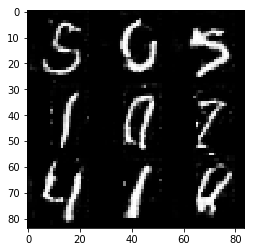

Epoch 2/2... Discriminator Loss: 1.7716... Generator Loss: 0.2695
Epoch 2/2... Discriminator Loss: 1.5949... Generator Loss: 0.3606


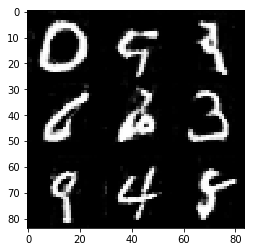

Epoch 2/2... Discriminator Loss: 1.5772... Generator Loss: 0.3850
Epoch 2/2... Discriminator Loss: 1.5174... Generator Loss: 0.4674


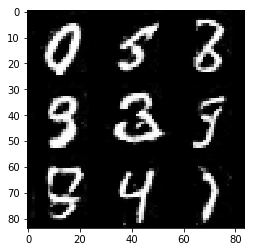

Epoch 2/2... Discriminator Loss: 0.6155... Generator Loss: 1.3033
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.6421


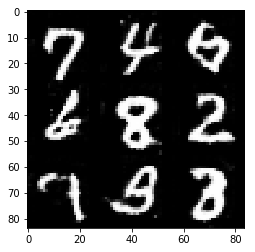

Epoch 2/2... Discriminator Loss: 1.6556... Generator Loss: 0.2991
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.5313


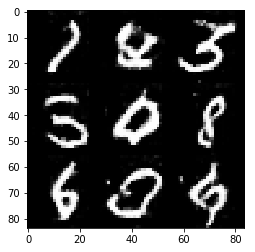

Epoch 2/2... Discriminator Loss: 1.0756... Generator Loss: 0.5746


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
    

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Tensor("discriminator_1/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Epoch 1/1... Discriminator Loss: 4.7898... Generator Loss: 0.0121
Epoch 1/1... Discriminator Loss: 4.5053... Generator Loss: 0.0187


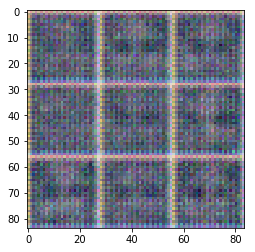

Epoch 1/1... Discriminator Loss: 2.1270... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 2.6176... Generator Loss: 0.2122


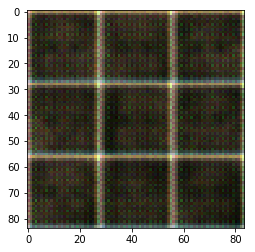

Epoch 1/1... Discriminator Loss: 2.5816... Generator Loss: 0.1262
Epoch 1/1... Discriminator Loss: 3.0114... Generator Loss: 0.0680


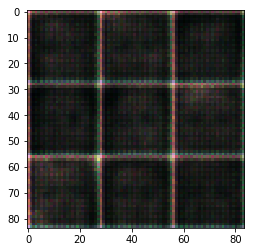

Epoch 1/1... Discriminator Loss: 2.3241... Generator Loss: 0.2526
Epoch 1/1... Discriminator Loss: 2.2585... Generator Loss: 0.1435


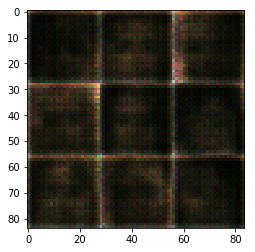

Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 1.9250
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 2.1386


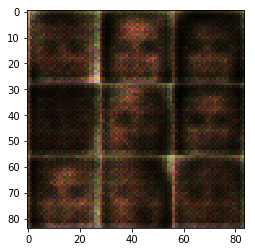

Epoch 1/1... Discriminator Loss: 2.1386... Generator Loss: 0.1762
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.5956


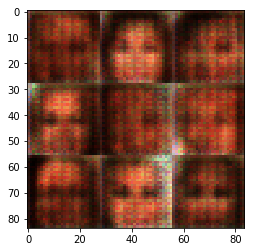

Epoch 1/1... Discriminator Loss: 2.1134... Generator Loss: 0.2883
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 2.8698


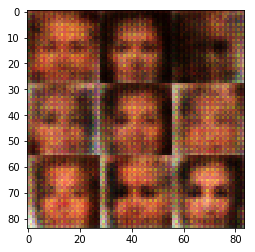

Epoch 1/1... Discriminator Loss: 2.0285... Generator Loss: 0.3230
Epoch 1/1... Discriminator Loss: 1.8763... Generator Loss: 0.3402


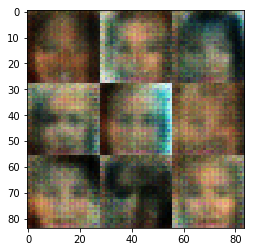

Epoch 1/1... Discriminator Loss: 2.4193... Generator Loss: 0.1721
Epoch 1/1... Discriminator Loss: 2.0354... Generator Loss: 0.2794


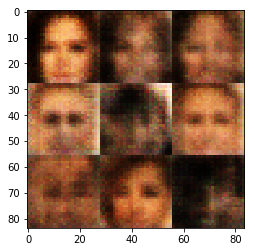

Epoch 1/1... Discriminator Loss: 2.0824... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 1.9407... Generator Loss: 0.4444


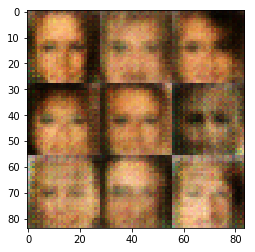

Epoch 1/1... Discriminator Loss: 1.7325... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 1.7631... Generator Loss: 0.4237


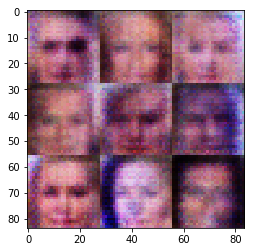

Epoch 1/1... Discriminator Loss: 2.2284... Generator Loss: 0.3319
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 0.4324


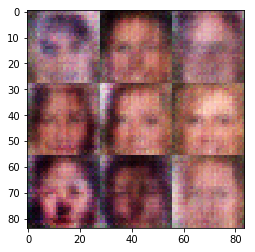

Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 0.4005


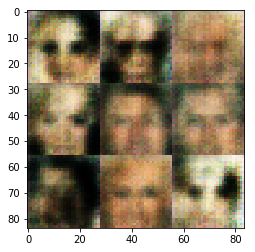

Epoch 1/1... Discriminator Loss: 1.6674... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.6571... Generator Loss: 0.4762


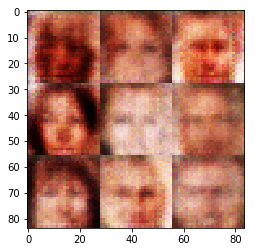

Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.7462... Generator Loss: 0.3887


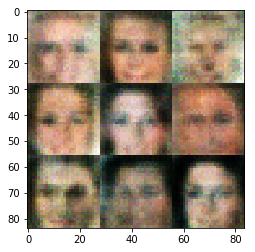

Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.5482


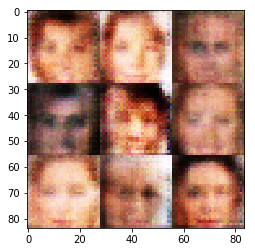

Epoch 1/1... Discriminator Loss: 1.8011... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.5457


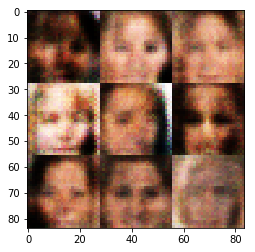

Epoch 1/1... Discriminator Loss: 1.7161... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.8467... Generator Loss: 0.4390


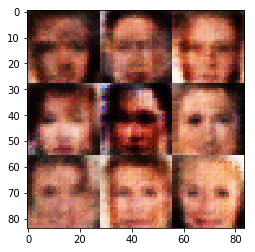

Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.6372... Generator Loss: 0.5608


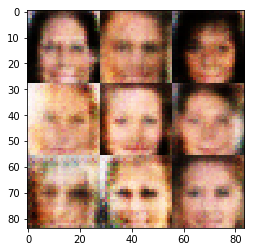

Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 0.4967


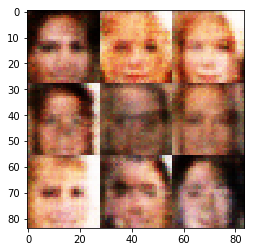

Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.6107


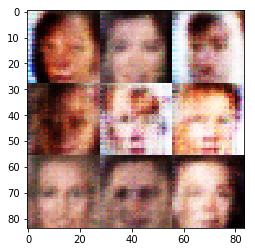

Epoch 1/1... Discriminator Loss: 1.6571... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.5356


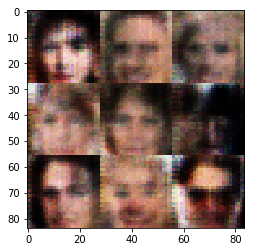

Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.4700


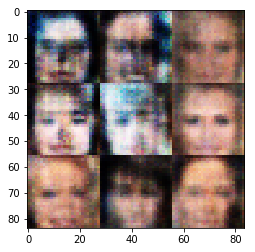

Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.7129... Generator Loss: 0.5317


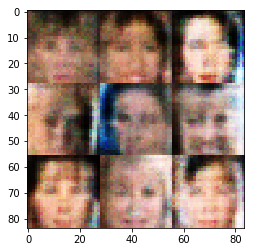

Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.5509


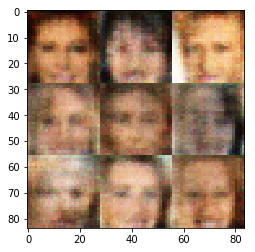

Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6228


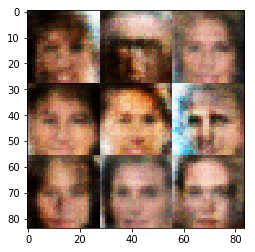

Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.5313


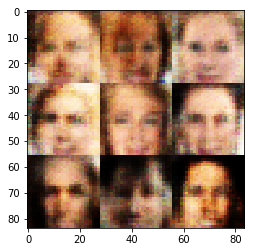

Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 0.6054


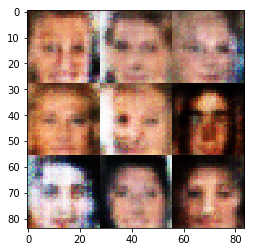

Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.5789


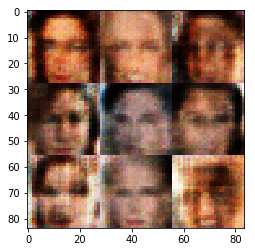

Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6370


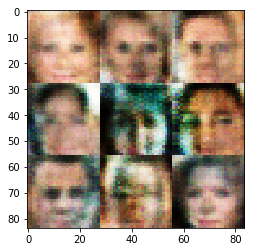

Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.5860


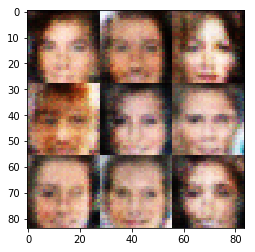

Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.6074


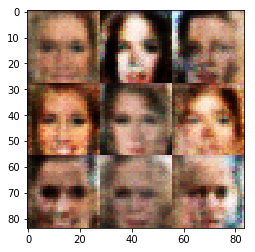

Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6500


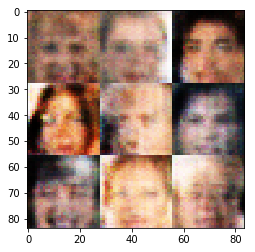

Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.7646... Generator Loss: 0.4265


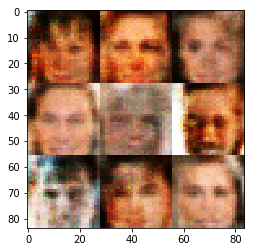

Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6113


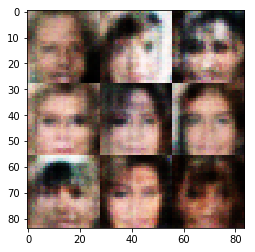

Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.5382


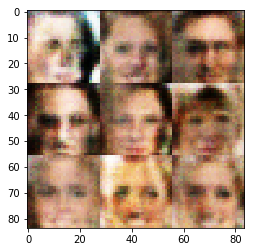

Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.5614


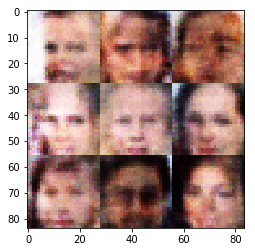

Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.5738


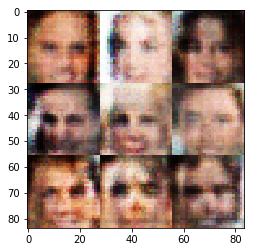

Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.5918


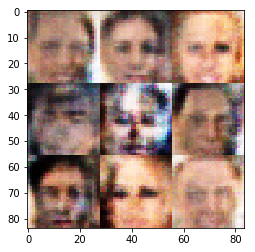

Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.6672... Generator Loss: 0.5638


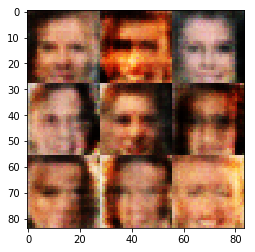

Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.6624... Generator Loss: 0.5405


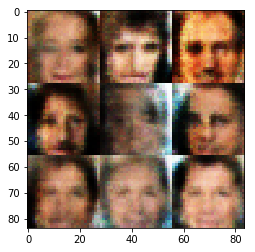

Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.6235


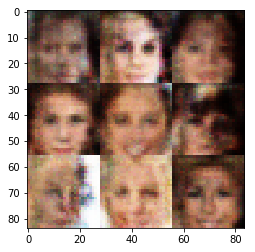

Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.5794


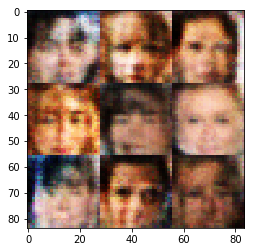

Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.5722


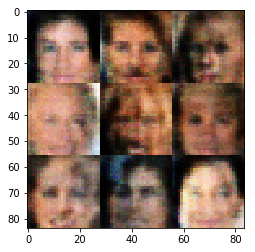

Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5840


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.